<a href="https://colab.research.google.com/github/Minh-A/Bitcoin_fluctuation_prediction/blob/main/Fluctuation_Prediction_Beta6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프리미엄과 금 데이터 제외 데이터(0.8)

## 데이터 전처리

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

# 성능지표
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as mt

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bnk/데이터/real_final_data.csv', encoding='cp949')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1202 non-null   object 
 1   Up/Down                  1202 non-null   object 
 2   원/달러(저가)                 1202 non-null   float64
 3   원/달러(종가)                 1202 non-null   float64
 4    open _x                 1202 non-null   int64  
 5    high _x                 1202 non-null   int64  
 6    low _x                  1202 non-null   int64  
 7    close _x                1202 non-null   int64  
 8   전일대비                     1202 non-null   int64  
 9   증감률                      1202 non-null   float64
 10   volume _x               1202 non-null   int64  
 11   value                   1202 non-null   float64
 12  MA(5)                    1202 non-null   int64  
 13  WMA(5)                   1202 non-null   int64  
 14  중심선                     

In [ ]:
data.head()

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,전일대비.1,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,low,close,volume,소비자물가지수,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all,reserve,reserve_usd
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,-1359000,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,8400.00,9014.23,38171.97003,247.87,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10,642450.952764,5.879285e+09
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,-660000,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,7540.00,8787.52,52039.26808,247.87,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10,661565.889330,5.853314e+09
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,8115.48,9240.00,23700.98509,247.87,1,1.34,46.188354,11.58,12.44,10.96,11.35,11.35,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10,659549.653501,6.003224e+09
3,2018-02-04,Down,1070.7,1079.7,9524000,10158000,8765000,8900000,-620000,-0.0651,18781,1.780000e+11,9865800,9491933,11299300,14522983,8.075617e+06,0.13,0.57,-620000,0,620000,195333.3333,760333.3333,0.256905,20.439484,11495016,13935244,-2440228,-2136697,26.289926,29.057600,9199.96,9368.00,7930.00,8184.81,32014,1080,8839595,9227.80,9350.00,7859.00,8167.91,24062.18196,247.87,1,1.34,49.654797,11.27,11.78,10.28,10.70,10.70,-1.121999,7571.180807,1.085739,1.693366,59.564491,-0.495010,1653.312875,1625.669332,5.134512,3.639219,681863.9489,5605143266,681863.9489,5605143266,144085.2127,1.184427e+09,24,632632.5583,5200445235,681863.9489,5605143266,1394810.224,11465793353,2076674.173,1.707094e+10,681863.948930,5.605143e+09
4,2018-02-05,Down,1087.6,1088.5,8900000,9250000,7715000,7832000,-1068000,-0.1200,20710,1.760000e+11,9146400,8814000,10794900,14426556,7.163244e+06,0.09,0.67,-1068000,0,1068000,281000.0000,804285.7143,0.349378,25.891799,10931475,13483151,-2551677,-2219693,3.099338,20.784003,8179.99,8382.80,6625.00,6939.99,63403,1089,7557649,8167.90,8349.16,6425.75,6905.19,59578.69822,247.

선형 보간법

In [ ]:
# 선형 보간법으로 결측치를 없앰
data1 = data.interpolate(method="linear")

In [ ]:
data1.head(3)

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,전일대비.1,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,low,close,volume,소비자물가지수,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all,reserve,reserve_usd
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,-1359000,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,8400.00,9014.23,38171.97003,247.87,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10,642450.952764,5.879285e+09
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,-660000,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,7540.00,8787.52,52039.26808,247.87,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10,661565.889330,5.853314e+09
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,8115.48,9240.00,23700.98509,247.87,1,1.34,46.188354,11.58,12.44,10.96,11.35,11.35,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10,659549.653501,6.003224e+09


데이터 셋 분류

In [ ]:
# 훈련데이터 셋과 테스트데이터 셋을 분류
train = data1.iloc[:-37,:]
test = data1.iloc[-37:,:]

In [ ]:
# 각 데이터 셋에서 Feature와 label을 분류
train_feature = train.iloc[:,2:]
train_label = train.iloc[:,1]

test_feature = test.iloc[:,2:]
test_label = test.iloc[:,1]

원핫인코딩 처리

In [ ]:
# label은 원핫인코딩 처리
train_label1 = pd.get_dummies(train_label)
test_label1 = pd.get_dummies(test_label)

In [ ]:
test_label1.head(5)

,Down,Up
1165,0,1
1166,1,0
1167,0,1
1168,1,0
1169,1,0


데이터 표준화를 사용

In [ ]:
# 데이터 표준화 (StandardScaler)
from sklearn.preprocessing import StandardScaler

# 훈련 데이터셋 feature
scaler = StandardScaler()

train_feature = scaler.fit_transform(train_feature)
train_feature = pd.DataFrame(train_feature)

# 테스트 데이터셋 feature
scaler = StandardScaler()

test_feature = scaler.fit_transform(test_feature)
test_feature1 = pd.DataFrame(test_feature)

train_feature.head(3), test_feature1.head(3)

(         0         1         2   ...        75        76        77
 0 -1.681571 -1.657008 -0.161469  ... -0.419979 -2.631205 -0.588361
 1 -1.633331 -1.487252 -0.264609  ... -0.434722 -2.534723 -0.590329
 2 -1.633331 -1.487252 -0.313335  ... -0.416904 -2.544900 -0.578970
 
 [3 rows x 78 columns],
          0         1         2   ...        75        76        77
 0 -0.509035  0.275729  1.415893  ...  0.937007 -0.988647  0.765055
 1  0.644749  0.885542  1.461128  ...  0.937007 -0.978112  0.734472
 2  1.229766  1.050356  1.363367  ...  1.775779 -0.855781  1.700895
 
 [3 rows x 78 columns])

슬라이딩 윈도우 1일로 데이터를 변환

In [ ]:
# (배치 사이즈, 날짜, 속성)으로 데이터 셋을 생성
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
# 데이터 셋을 슬라이딩 윈도우 형식으로 만들기
# 7일으로 설정

# 훈련데이터 셋
train_feature1, train_label = make_dataset(train_feature, train_label1, 7)

#테스트 데이터 셋
test_feature, test_label = make_dataset(test_feature1, test_label1, 7)

x_train = train_feature1
y_train = train_label

x_train.shape, y_train.shape, test_label.shape


((1158, 7, 78), (1158, 2), (30, 2))

## 모델링: GRU

> 모델 설명

* 1개의 인풋 레이어와 5개의 히든 레이어, 1개의 아웃풋 레이어로 구성
* 5층의 히든 레이어는 각각 32, 64, 128, 256, 512개의 노드로 구성됨
* 각 노드는 GRU를 사용하였으며, 활성화 함수로 Tanh를 사용함
* 아웃풋 레이어는 2개의 노드이며, 활성화 함수로 softmax를 사용함

> 모델 학습 설명
* 모델 학습의 손실함수로는 binary_crossentropy를 사용함
* 최적화로는 adam을 사용함
* epochs는 31번으로 구성됨

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import tensorflow as tf

tf.random.set_seed(2)

model = Sequential()

model.add(GRU(32, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

model.add(GRU(64, 
               activation='tanh', return_sequences = True))

model.add(GRU(128, 
               activation='tanh', return_sequences = True))

model.add(GRU(256, 
               activation='tanh', return_sequences = True))

model.add(GRU(512, 
               activation='tanh'))

model.add(Dense(2, activation='softmax'))

In [ ]:
# 모델 확인
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_220 (GRU)                (None, 7, 32)             10752     
_________________________________________________________________
gru_221 (GRU)                (None, 7, 64)             18816     
_________________________________________________________________
gru_222 (GRU)                (None, 7, 128)            74496     
_________________________________________________________________
gru_223 (GRU)                (None, 7, 256)            296448    
_________________________________________________________________
gru_224 (GRU)                (None, 512)               1182720   
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 1026      
Total params: 1,584,258
Trainable params: 1,584,258
Non-trainable params: 0
___________________________________________

In [ ]:
# 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=31, epochs=31)  

Epoch 1/31
38/38 [==============================] - 6s 9ms/step - loss: 0.6931 - accuracy: 0.5047
Epoch 2/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6879 - accuracy: 0.5541
Epoch 3/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6804 - accuracy: 0.5794
Epoch 4/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6840 - accuracy: 0.5510
Epoch 5/31
38/38 [==============================] - 0s 9ms/step - loss: 0.6801 - accuracy: 0.5807
Epoch 6/31
38/38 [==============================] - 0s 9ms/step - loss: 0.6818 - accuracy: 0.5521
Epoch 7/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6781 - accuracy: 0.5691
Epoch 8/31
38/38 [==============================] - 0s 9ms/step - loss: 0.6694 - accuracy: 0.5921
Epoch 9/31
38/38 [==============================] - 0s 9ms/step - loss: 0.6832 - accuracy: 0.5396
Epoch 10/31
38/38 [==============================] - 0s 8ms/step - loss: 0.6672 - accuracy: 0.5897
Epoch 11/31
38/38 [

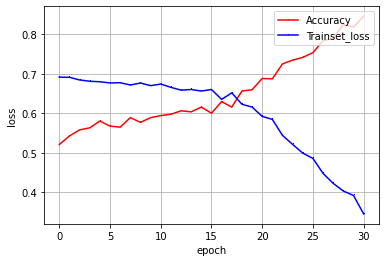

In [ ]:
# 모델 loss 그래프

y_test_loss = history.history['accuracy']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))
plt.plot(x_len, y_test_loss, marker=',', c='red', label='Accuracy')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

모델 예측

In [ ]:
# 모델 예측
pred = model.predict(test_feature)
pred

array([[9.9495924e-01, 5.0407941e-03],
       [9.5031875e-01, 4.9681280e-02],
       [9.9549389e-01, 4.5061554e-03],
       [9.9996078e-01, 3.9195485e-05],
       [9.9670261e-01, 3.2974416e-03],
       [2.2274912e-04, 9.9977726e-01],
       [9.9999034e-01, 9.6192744e-06],
       [9.9987161e-01, 1.2841090e-04],
       [5.8935042e-03, 9.9410653e-01],
       [2.6340117e-03, 9.9736601e-01],
       [4.4381604e-01, 5.5618399e-01],
       [6.1195754e-03, 9.9388039e-01],
       [9.8795742e-01, 1.2042609e-02],
       [9.8072313e-02, 9.0192771e-01],
       [9.9965513e-01, 3.4490664e-04],
       [9.9994242e-01, 5.7571113e-05],
       [9.9866724e-01, 1.3327517e-03],
       [1.8028609e-03, 9.9819714e-01],
       [1.8452521e-04, 9.9981552e-01],
       [2.3807145e-03, 9.9761921e-01],
       [1.4337413e-01, 8.5662585e-01],
       [9.6647614e-01, 3.3523887e-02],
       [6.8860233e-01, 3.1139767e-01],
       [9.8785257e-01, 1.2147445e-02],
       [7.4468094e-01, 2.5531906e-01],
       [5.7641586e-04, 9.

예측값을 원핫인코딩으로 전환

In [ ]:
# 위치를 숫자로 반환
preds = np.argmax(pred, axis=1)
preds

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
# 원핫인코딩
preds1 = pd.get_dummies(preds)
preds1

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1
6,1,0
7,1,0
8,0,1
9,0,1


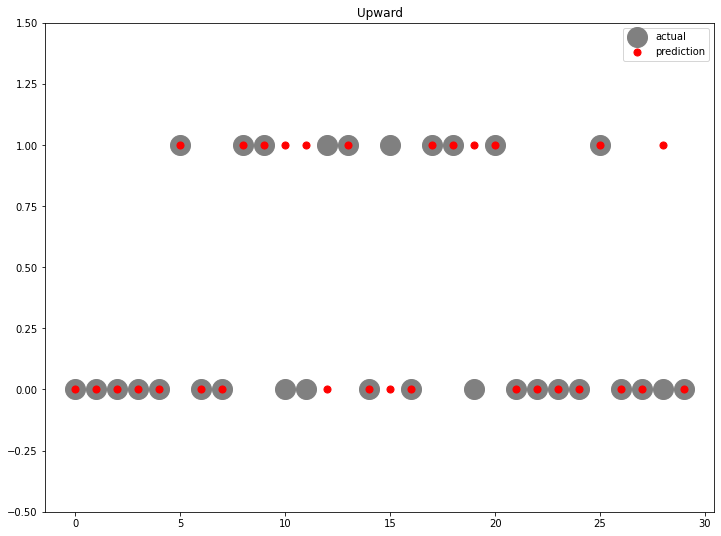

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(pd.DataFrame(test_label).index, test_label[:,1], label = 'actual', s = 400, c = 'gray')
plt.scatter(pd.DataFrame(test_label).index, preds1[1], label = 'prediction', s= 50, c = 'red')
plt.ylim([-0.5, 1.5])
plt.title("Upward") 
plt.legend()
plt.show()

성능지표

In [ ]:
test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가: 하나로 묶어서
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds, target_names=['하락', '상승']))

accuracy 0.8
[[16  4]
 [ 2  8]]
              precision    recall  f1-score   support

          하락       0.89      0.80      0.84        20
          상승       0.67      0.80      0.73        10

    accuracy                           0.80        30
   macro avg       0.78      0.80      0.78        30
weighted avg       0.81      0.80      0.80        30



# RF를 통해 뽑은 데이터(0.63)

RF를 통해 뽑은 feature_importances 17개

In [ ]:
start = time.time()

# 랜덤으로 할 파라미터 정의
param_list = {"n_estimators": list(range(20, 200, 20)),
              "max_depth": list(range(4, 21, 4)),
              "max_features": list(range(5, 40, 5)),
              "min_samples_split": list(range(3, 13, 2))}

# 하이퍼파라미터 최적화
RF = RandomForestClassifier()
RF_random_search = RandomizedSearchCV(estimator = RF,
                                        param_distributions = param_list,
                                        n_iter = 3,       # 5번 반복하는 랜덤포레스트를 구현
                                        cv = 3,           # 3번의 cross-validation
                                        n_jobs = 10,
                                        random_state=42) 
RF_random_search.fit(X_train, y_train)
y_pred = RF_random_search.predict(X_test)

#성능평가
print('accuracy',mt.accuracy_score(y_test,y_pred))

print( clock(start) )
print( RF_random_search.best_params_ ) #파라미터 중 가장 정확도가 높은 파라미터를 출력
#가장 추정이 잘된 변수명들의 정확도를 순서대로 나열함
f_i1 = pd.DataFrame(sorted(zip(RF_random_search.best_estimator_.feature_importances_*100, X_train.columns), reverse=True), columns=['f_i','columns'])
f_i1.head(20)

accuracy 1.0
0:00:01
{'n_estimators': 120, 'min_samples_split': 3, 'max_features': 30, 'max_depth': 12}


,f_i,columns
0,32.225334,전일대비
1,31.628684,상승분
2,27.547967,증감률
3,6.306189,하락분
4,1.452947,%K
5,0.553102,%B
6,0.138718,%D
7,0.080969,프리미엄%_업비트
8,0.013900,outflow_top10
9,0.013022,reserve_bi


데이터 확인

In [ ]:
# 17개의 특징들
Features = ['date'	,'Up/Down', '전일대비', '상승분', '증감률', '하락분', '%K', '%B', '%D', '프리미엄%_업비트', 'outflow_top10', 'reserve_bi', 'mpi', '원/달러(저가)', 'reserve_der', 'reserve_x', '받으실 때', 'reserve_usd_der', 'stock_to_flow']

In [ ]:
# 데이터 확인
data.loc[:,Features]

,date,Up/Down,전일대비,상승분,증감률,하락분,%K,%B,%D,프리미엄%_업비트,outflow_top10,reserve_bi,mpi,원/달러(저가),reserve_der,reserve_x,받으실 때,reserve_usd_der,stock_to_flow
0,2018-02-01,Down,-1359000,0,-0.1189,1359000,1.657769,-0.09,16.048295,1.843100,1546.358399,151633.7371,0.001605,1068.5,6.424510e+05,6.424510e+05,0.003900,5879284961,8419.788648
1,2018-02-02,Down,-660000,0,-0.0655,660000,27.920127,0.00,20.679488,-1.776700,890.894902,150398.1722,-0.615347,1070.7,6.615659e+05,6.615659e+05,-0.007800,5853314467,8019.846331
2,2018-02-03,Up,110000,110000,0.0117,0,32.962746,0.13,20.846881,0.041433,122.518562,149015.1937,-0.947008,1070.7,6.595497e+05,6.595497e+05,-0.005367,6003224244,8528.431542
3,2018-02-04,Down,-620000,0,-0.0651,620000,26.289926,0.13,29.057600,1.859567,1625.669332,144085.2127,-0.495010,1070.7,6.818639e+05,6.818639e+05,-0.002933,5605143266,7571.180807
4,2018-02-05,Down,-1068000,0,-0.1200,1068000,3.099338,0.09,20.784003,3.677700,126.968730,139922.2262,-0.850115,1087.6,7.011784e+05,7.011784e+05,-0.000500,4858822798,7285.703698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2021-05-13,Up,812000,812000,0.0130,0,22.190425,0.09,26.409802,12.435600,161.864237,494571.9322,-0.257674,1128.3,1.261852e+06,1.261852e+06,0.000600,62685006732,18593.170360
1198,2021-05-14,Down,-1272000,0,-0.0202,1272000,13.026101,0.10,15.548754,9.859300,156.042859,499984.4923,-0.465309,1127.5,1.269391e+06,1.269391e+06,0.007700,63319768235,22340.555440
1199,2021-05-15,Down,-2990000,0,-0.0484,2990000,6.548736,0.06,13.921754,8.966567,133.074438,500276.9622,-0.690489,1127.5,1.275133e+06,1.275133e+06,0.010500,59623423482,24339.491290
1200,2021-05-16,Down,-1158000,0,-0.0197,1158000,14.327622,0.12,11.300820,8.073833,136.720889,500793.1944,-0.660113,1127.5,1.278611e+06,1.278611e+06,0.013300,59366258340,22680.980520


모델링

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import tensorflow as tf

tf.random.set_seed(2)

model = Sequential()

model.add(GRU(32, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

model.add(GRU(64, 
               activation='tanh', return_sequences = True))

model.add(GRU(128, 
               activation='tanh', return_sequences = True))

model.add(GRU(256, 
               activation='tanh', return_sequences = True))

model.add(GRU(512, 
               activation='tanh'))

model.add(Dense(2, activation='softmax'))

In [ ]:
# 학습된 모델 불러오기
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/bnk/활용 모델/GRU_SelectedVariables_0.63_model3114.h5')

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_70 (GRU)                 (None, 7, 32)             4896      
_________________________________________________________________
gru_71 (GRU)                 (None, 7, 64)             18816     
_________________________________________________________________
gru_72 (GRU)                 (None, 7, 128)            74496     
_________________________________________________________________
gru_73 (GRU)                 (None, 7, 256)            296448    
_________________________________________________________________
gru_74 (GRU)                 (None, 512)               1182720   
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 1026      
Total params: 1,578,402
Trainable params: 1,578,402
Non-trainable params: 0
___________________________________________

In [ ]:
# 모델 예측
pred = model.predict(test_feature)

preds = np.argmax(pred, axis=1)

preds1 = pd.get_dummies(preds)

test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds, target_names=['하락', '상승']))

accuracy 0.6333333333333333
[[12  8]
 [ 3  7]]
              precision    recall  f1-score   support

          하락       0.80      0.60      0.69        20
          상승       0.47      0.70      0.56        10

    accuracy                           0.63        30
   macro avg       0.63      0.65      0.62        30
weighted avg       0.69      0.63      0.64        30



# 모든 데이터(0.73)

데이터

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bnk/데이터/final_data_0601_3.csv', encoding='cp949')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 84 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1202 non-null   object 
 1   Up/Down                  1202 non-null   object 
 2   원/달러(저가)                 1202 non-null   float64
 3   원/달러(종가)                 1202 non-null   float64
 4    open _x                 1202 non-null   int64  
 5    high _x                 1202 non-null   int64  
 6    low _x                  1202 non-null   int64  
 7    close _x                1202 non-null   int64  
 8   전일대비                     1202 non-null   int64  
 9   증감률                      1202 non-null   float64
 10   volume _x               1202 non-null   int64  
 11   value                   1202 non-null   float64
 12  MA(5)                    1202 non-null   int64  
 13  WMA(5)                   1202 non-null   int64  
 14  중심선                     

In [ ]:
data.head()

,date,Up/Down,원/달러(저가),원/달러(종가),open _x,high _x,low _x,close _x,전일대비,증감률,volume _x,value,MA(5),WMA(5),중심선,상한선,하한선,%B,band width,상승분,하락분,AU,AD,RS,RSI,12EMA,26EMA,MACD,MACD 시그널,%K,%D,open _y,high _y,low _y,close _y,volume _y,환률,원화환산,open,high,...,등락,등락률,market_premium,price_usd_open,price_usd_high,price_usd_low,price_usd_close,price_usd_adj_close,nvt_golden_cross,stock_to_flow,stock_to_flow_reversion,puell_multiple,stablecoin_supply_ratio,mpi,outflow_total,outflow_top10,outflow_mean,outflow_mean_ma7,reserve_x,reserve_usd_x,reserve_y,reserve_usd_y,reserve_bi,reserve_usd_bi,FGI,reserve_co,reserve_usd_co,reserve_der,reserve_usd_der,reserve_spot,reserve_usd_spot,reserve_all,reserve_usd_all,reserve,reserve_usd,파실 때,보내실 때,받으실 때,프리미엄%_업비트,프리미엄%_코인베이스
0,2018-02-01,Down,1068.5,1071.9,11439000,11490000,10011000,10070000,-1359000,-0.1189,22226,2.370000e+11,11877400,11341133,12472700,14525823,1.041958e+07,-0.09,0.33,0,1359000,261666.6667,642666.6667,0.407158,28.934759,12957482,15148589,-2191106,-1901065,1.657769,16.048295,10285.10,10335.00,8750.99,9224.52,33565,1072,9888685,10099.99,10166.25,...,1,1.34,51.312679,14.25,14.25,12.05,13.11,13.11,-0.974258,8419.788648,1.086884,1.784690,66.507798,0.001605,1596.374355,1546.358399,8.582658,2.540632,642450.9528,5879284961,642450.9528,5879284961,151633.7371,1.387651e+09,30,631190.6195,5776237860,642450.9528,5879284961,1393822.705,12755340828,2036273.658,1.863463e+10,642450.9528,5879284961,1344.300000,5.3,0.003900,1.843100,-2.2797
1,2018-02-02,Down,1070.7,1079.7,10061000,10120000,7830000,9410000,-660000,-0.0655,52018,4.660000e+11,11089000,10518667,12099600,14788820,9.410380e+06,0.00,0.44,0,660000,238000.0000,645142.8571,0.368911,26.949207,12411716,14723508,-2311792,-1983211,27.920127,20.679488,9224.52,9250.00,8010.02,8873.03,49972,1080,9582872,9014.22,9090.08,...,1,1.34,42.721911,11.89,13.10,11.64,12.00,12.00,-1.198093,8019.846331,1.103221,1.719647,64.552097,-0.615347,946.366655,890.894902,6.267329,3.326606,661565.8893,5853314467,661565.8893,5853314467,150398.1722,1.330673e+09,15,631669.5173,5588801332,661565.8893,5853314467,1398605.628,12374396391,2060171.517,1.822771e+10,661565.8893,5853314467,1333.700000,10.6,-0.007800,-1.776700,-0.9637
2,2018-02-03,Up,1070.7,1079.7,9410000,10200000,8400000,9520000,110000,0.0117,25406,2.360000e+11,10411200,9995667,11706600,14630024,8.783176e+06,0.13,0.50,110000,0,195333.3333,673166.6667,0.290171,22.490885,11966837,14338063,-2371226,-2060814,32.962746,20.846881,8873.03,9473.01,8229.00,9199.96,28725,1080,9935957,8787.52,9499.00,...,1,1.34,46.188354,11.58,12.44,10.96,11.35,11.35,-0.999548,8528.431542,1.067254,1.583934,67.256738,-0.947008,145.367410,122.518562,0.685695,3.184920,659549.6535,6003224244,659549.6535,6003224244,149015.1937,1.356337e+09,40,631970.2084,5752195997,659549.6535,6003224244,1397086.223,12716285790,2056635.877,1.871951e+10,659549.6535,6003224244,1333.466667,7.3,-0.005367,0.041433,-0.8096
3,2018-02-04,Down,1070.7,1079.7,9524000,10158000,8765000,8900000,-620000,-0.0651,18781,1.780000e+11,9865800,9491933,11299300,14522983,8.075617e+06,0.13,0.57,0,620000,195333.3333,760333.3333,0.256905,20.439484,11495016,13935244,-2440228,-2136697,26.289926,29.057600,9199.96,9368.00,7930.00,8184.81,32014,1080,8839595,9227.80,9350.00,...,1,1.34,49.654797,11.27,11.78,10.28,10.70,10.70,-1.121999,7571.180807,1.085739,1.693366,59.564491,-0.495010,1653.312875,1625.669332,5.134512,3.639219,681863.9489,5605143266,681863.9489,5605143266,144085.2127,1.184427e+09,24,632632.5583,5200445235,681863.9489,5605143266,1394810.224,11465793353,2076674.173,1.707094e+10,681863.9489,5605143266,1333.233333,4.0,-0.002933,1.859567,-0.6555
4,2018-02-05,Down,1087.6,1088.5,8900000,9250000,7715000,7832000,-1068000,-0.1200,20710,1.760000e+11,9146400,8814000,10794900,14426556,7.163244e+06,0.09,0.67,0,1068000,281000.0000,804285.7143,0.349378,25.891799,10931475,13483151,-2551677,-2219693,3.099338,20.784003,8179.99,8382.80,6625.00,6939.99,63403,1089,7557649,8167.90,8349.16,...,1,1.34,53.121239,10.96,11

모델링

In [ ]:
# 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import tensorflow as tf

tf.random.set_seed(2)

model = Sequential()

model.add(GRU(32, 
               input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

model.add(GRU(64, 
              input_shape=(train_feature1.shape[1], train_feature1.shape[2]), 
               activation='tanh', return_sequences = True))

model.add(GRU(128, 
               activation='tanh', return_sequences = True))

model.add(GRU(256, 
               activation='tanh', return_sequences = True))

model.add(GRU(512, 
               activation='tanh'))

model.add(Dense(2, activation='softmax'))

In [ ]:
# 학습된 모델 불러오기
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/bnk/활용 모델/GRU_FullVariables_0.73_model3225.h5')

model1.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_675 (GRU)                (None, 7, 32)             11136     
_________________________________________________________________
gru_676 (GRU)                (None, 7, 64)             18816     
_________________________________________________________________
gru_677 (GRU)                (None, 7, 128)            74496     
_________________________________________________________________
gru_678 (GRU)                (None, 7, 256)            296448    
_________________________________________________________________
gru_679 (GRU)                (None, 512)               1182720   
_________________________________________________________________
dense_135 (Dense)            (None, 2)                 1026      
Total params: 1,584,642
Trainable params: 1,584,642
Non-trainable params: 0
__________________________________________

In [ ]:
# 모델 예측
pred = model1.predict(test_feature)

preds = np.argmax(pred, axis=1)

preds1 = pd.get_dummies(preds)

test_label1 = np.array(test_label).argmax(axis=1)

# 성능평가
print('accuracy',mt.accuracy_score(test_label1,preds))
print(confusion_matrix(test_label1, preds))
print(classification_report(test_label1, preds, target_names=['하락', '상승']))

accuracy 0.7333333333333333
[[14  6]
 [ 2  8]]
              precision    recall  f1-score   support

          하락       0.88      0.70      0.78        20
          상승       0.57      0.80      0.67        10

    accuracy                           0.73        30
   macro avg       0.72      0.75      0.72        30
weighted avg       0.77      0.73      0.74        30

